In [1]:
import torch
import numpy as np
import gymnasium as gym

import sys
sys.path.append('../../..')
from tools.trainer import Trainer
from tools.logger import Logger
from environments.hockey_wrapper import HockeyWrapper
from TD3 import TD3Agent

In [2]:
env_string = "Hockey"

In [3]:
if env_string == "Hockey":
    env = HockeyWrapper(mode="normal", opponent="weak")
else:
    env = gym.make(env_string)

In [4]:
agent = TD3Agent(env.observation_space, env.action_space)

In [5]:
trainer = Trainer()
ep_rewards = trainer.train(env, agent, n_episodes=30000, test_every=100, noise=0.2)

Step 101/30000:
                    test reward: -19.87
                    mean reward: -19.74, max reward: 9.54
                    Avg. step number: 235.1, Avg ep duration: 0.061s
                    Avg. train duration: 0.264s
            
Step 201/30000:
                    test reward: -22.19
                    mean reward: -17.77, max reward: 9.30
                    Avg. step number: 228.2, Avg ep duration: 0.059s
                    Avg. train duration: 0.262s
            
Step 301/30000:
                    test reward: -10.88
                    mean reward: -18.32, max reward: 8.45
                    Avg. step number: 215.8, Avg ep duration: 0.056s
                    Avg. train duration: 0.264s
            
Step 401/30000:
                    test reward: -10.21
                    mean reward: -9.97, max reward: 9.72
                    Avg. step number: 233.9, Avg ep duration: 0.061s
                    Avg. train duration: 0.264s
            
Step 501/30000:
         

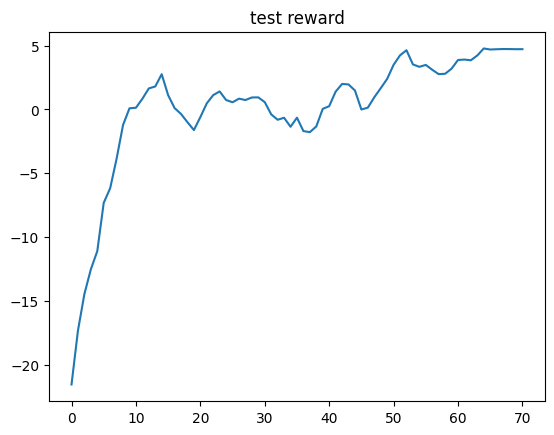

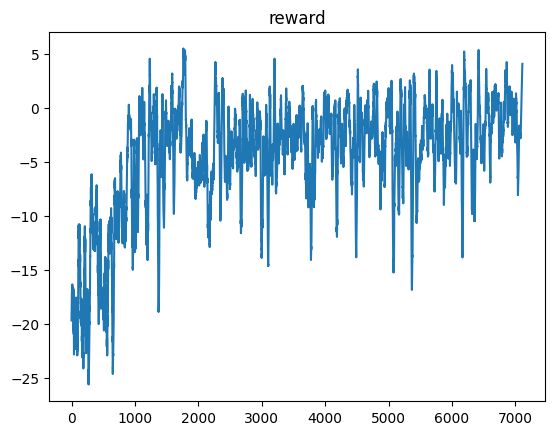

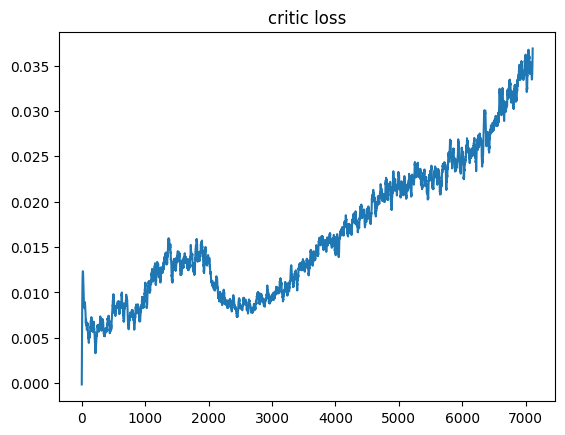

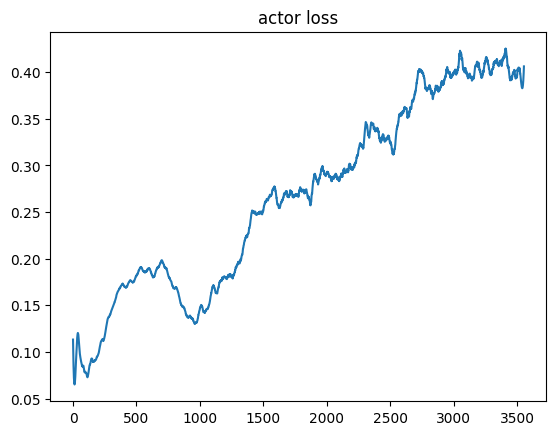

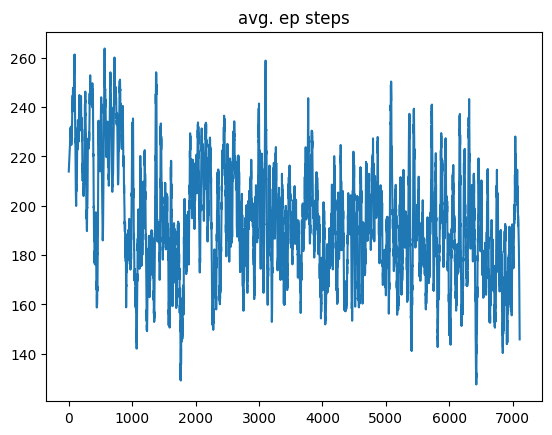

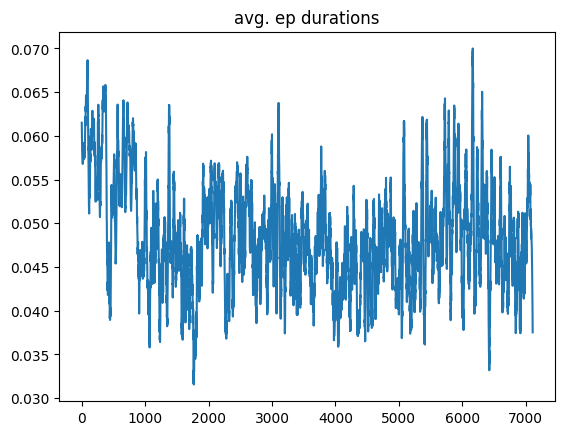

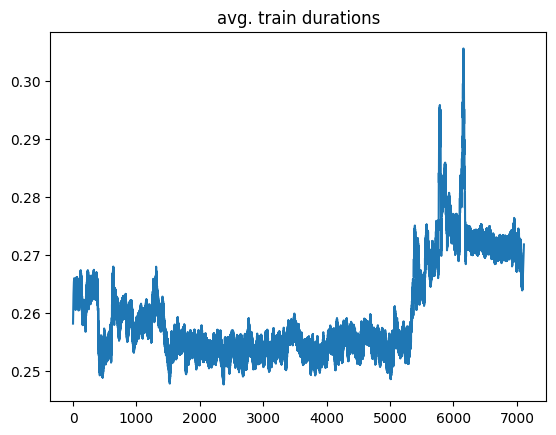

In [6]:
trainer.logger.plot()

In [6]:
def play(env_string, agent, n_episodes=10, noise=0):
    if env_string == 'Hockey':
        env = HockeyWrapper(mode='normal', opponent='weak')    
    else:
        env = gym.make(env_string, render_mode='human')
    steps, rewards, observations, actions = Trainer.run(env, agent, n_episodes=n_episodes, noise=noise)
    env.close()
    return steps, rewards, observations, actions

In [7]:
steps, rewards, observations, actions = play(env_string, agent, n_episodes=10, noise=0)
print(np.mean(rewards))

4.676429279605437


In [ ]:
trainer.logger.save("logs/lunar_lander_td3.npy")

In [18]:
# torch.save(agent.state(), 'checkpoint_hockey.pth')

In [5]:
# agent_state = torch.load('checkpoint_hockey.pth')
# agent.restore_state(agent_state)